In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the data

In [3]:
# file paths
train_path = "../data/preprocessed/train_vectors_scaled.csv"
test_path = "../data/preprocessed/test_vectors_scaled.csv"
gen_path = "../data/preprocessed/generalisation_vectors_scaled.csv"

In [4]:
# load the dataframes
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
gen_df = pd.read_csv(gen_path)

In [8]:
def preprocess(df, label_encoder = None, cols_to_drop = []):
    # get target features
    data_df = df.drop(columns=['Type'])
    data_df.drop(columns=['is_synthetic'], inplace = True, errors ='ignore')
    data_df = data_df.reindex(sorted(data_df.columns), axis=1)
    target_df = df['Type']

    # encode target labels
    if label_encoder is None:
        label_encoder = LabelEncoder()
        label_encoder.fit(target_df)
    target_df = label_encoder.transform(target_df)

    # drop other columns if needed
    data_df = data_df.drop(columns=cols_to_drop)

    X = data_df.to_numpy()
    y = target_df

    return X, y, label_encoder

In [48]:
# preprocess the datasets
X_train_, y_train_, target_label_encoder =  preprocess(train_df)
X_test, y_test, _ =  preprocess(test_df, label_encoder=target_label_encoder)
X_gen, y_gen, _ =  preprocess(gen_df, label_encoder=target_label_encoder)

In [49]:
print(X_train_.shape, X_test.shape, X_gen.shape)

(2941485, 30) (1233449, 30) (2446687, 30)


In [50]:
y_train_.shape

(2941485,)

In [51]:
# train test split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_, y_train_, test_size=0.2, random_state=42)

In [52]:
print(X_train.shape, X_valid.shape, X_test.shape, X_gen.shape)

(2353188, 30) (588297, 30) (1233449, 30) (2446687, 30)


# Hyperparameter optimistaion

In [53]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [63]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 50,
        'seed': 0
    }

In [64]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), verbosity=0, silent =True, eval_metric="merror",
                        early_stopping_rounds=10,)
                
    evaluation = [( X_train, y_train), ( X_valid, y_valid)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, verbose=False)
    

    pred = clf.predict(X_valid)
    accuracy = accuracy_score(y_valid, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }


In [65]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

SCORE:                                                
0.820944182955208                                     
SCORE:                                                                          
0.8035703054749557                                                              
SCORE:                                                                          
0.8754013703962454                                                              
SCORE:                                                                           
0.8685969841763599                                                               
SCORE:                                                                           
0.8708730454175357                                                               
SCORE:                                                                           
0.8645565080223084                                                               
SCORE:                                                                    

In [66]:
best_hyperparams

{'colsample_bytree': 0.8913274327728182,
 'gamma': 5.12997338345139,
 'max_depth': 18.0,
 'min_child_weight': 0.0,
 'reg_alpha': 42.0,
 'reg_lambda': 0.7702008901893513}

# Train the model

In [68]:
# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42, n_estimators = 300, max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
                    reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                    colsample_bytree=int(best_hyperparams['colsample_bytree'])

)

# Train the classifier on the training data and evaluate on the validation set
xgb_classifier.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=['merror'], early_stopping_rounds=5)

c:\Users\Maya\.conda\envs\ddos\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Maya\.conda\envs\ddos\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-merror:0.53390
[1]	validation_0-merror:0.53330
[2]	validation_0-merror:0.48938
[3]	validation_0-merror:0.53119
[4]	validation_0-merror:0.49712
[5]	validation_0-merror:0.46634
[6]	validation_0-merror:0.46616
[7]	validation_0-merror:0.41910
[8]	validation_0-merror:0.35207
[9]	validation_0-merror:0.35185
[10]	validation_0-merror:0.33564
[11]	validation_0-merror:0.33711
[12]	validation_0-merror:0.28671
[13]	validation_0-merror:0.28389
[14]	validation_0-merror:0.28700
[15]	validation_0-merror:0.28203
[16]	validation_0-merror:0.28397
[17]	validation_0-merror:0.28590
[18]	validation_0-merror:0.28311
[19]	validation_0-merror:0.28756
[20]	validation_0-merror:0.25609
[21]	validation_0-merror:0.25164
[22]	validation_0-merror:0.25427
[23]	validation_0-merror:0.25424
[24]	validation_0-merror:0.22901
[25]	validation_0-merror:0.22343
[26]	validation_0-merror:0.21614
[27]	validation_0-merror:0.21792
[28]	validation_0-merror:0.21860
[29]	validation_0-merror:0.21136
[30]	validation_0-me

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=5.12997338345139,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

Accuracy: 0.7792198947828406


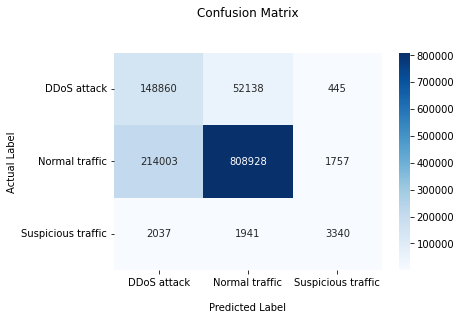

In [75]:
# Make predictions on the test data
y_pred = xgb_classifier.predict(X_test)

# Calculate accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cf_matrix = confusion_matrix(y_test, y_pred)

class_names = target_label_encoder.inverse_transform([0,1,2])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt = 'd', xticklabels=class_names, yticklabels=class_names)

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label')

## Display the visualization of the Confusion Matrix.
plt.show()

In [77]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.74      0.53    201443
           1       0.94      0.79      0.86   1024688
           2       0.60      0.46      0.52      7318

    accuracy                           0.78   1233449
   macro avg       0.65      0.66      0.63   1233449
weighted avg       0.85      0.78      0.80   1233449



Accuracy: 0.8583003142970302


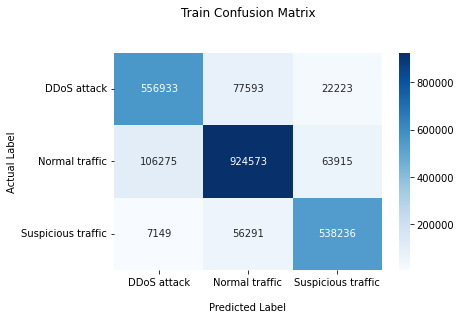

In [78]:
# Make predictions on the train data
y_pred = xgb_classifier.predict(X_train)

# Calculate accuracy of the model
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

cf_matrix = confusion_matrix(y_train, y_pred)

class_names = target_label_encoder.inverse_transform([0,1,2])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt = 'd', xticklabels=class_names, yticklabels=class_names)

ax.set_title('Train Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label')

## Display the visualization of the Confusion Matrix.
plt.show()

Accuracy: 0.859139176300406


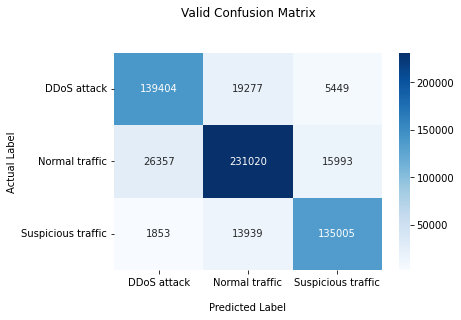

In [79]:
# Make predictions on the valid data
y_pred = xgb_classifier.predict(X_valid)

# Calculate accuracy of the model
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", accuracy)

cf_matrix = confusion_matrix(y_valid, y_pred)

class_names = target_label_encoder.inverse_transform([0,1,2])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt = 'd', xticklabels=class_names, yticklabels=class_names)

ax.set_title('Valid Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label')

## Display the visualization of the Confusion Matrix.
plt.show()

Accuracy: 0.7807708955007322


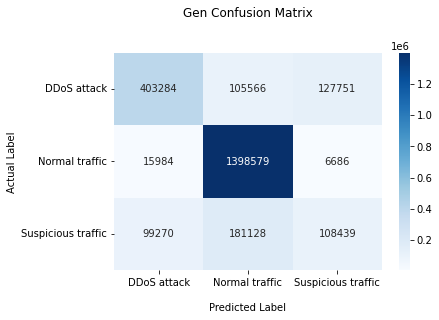

In [80]:
# Make predictions on the gen data
y_pred = xgb_classifier.predict(X_gen)

# Calculate accuracy of the model
accuracy = accuracy_score(y_gen, y_pred)
print("Accuracy:", accuracy)

cf_matrix = confusion_matrix(y_gen, y_pred)

class_names = target_label_encoder.inverse_transform([0,1,2])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt = 'd', xticklabels=class_names, yticklabels=class_names)

ax.set_title('Gen Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label')

## Display the visualization of the Confusion Matrix.
plt.show()

In [81]:
print(classification_report(y_gen, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.63      0.70    636601
           1       0.83      0.98      0.90   1421249
           2       0.45      0.28      0.34    388837

    accuracy                           0.78   2446687
   macro avg       0.68      0.63      0.65   2446687
weighted avg       0.76      0.78      0.76   2446687



In [84]:
feature_importance= xgb_classifier.feature_importances_

# Map feature importance scores to feature names

feature_names = train_df.reindex(sorted(train_df.columns), axis=1).drop(columns=['Type', 'is_synthetic']).columns
feature_importance_map = dict(zip(feature_names, feature_importance))

# Sort feature importance scores
sorted_feature_importance = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

# Print feature importance scores
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

Suspicious traffic: 0.2171708345413208
High volume traffic: 0.18517321348190308
Significant flag: 0.14632369577884674
DNS: 0.0985897034406662
NTP: 0.0433206781744957
Source IP count: 0.03922516107559204
is_weekday: 0.03727903217077255
victim IP num: 0.03262806311249733
ICMP: 0.03250408545136452
CLDAP: 0.027677031233906746
Generic UDP: 0.02098415046930313
Avg packet len: 0.018923407420516014
Data speed: 0.018063202500343323
Attack duration: 0.017911236733198166
Port number: 0.015392553992569447
IPv4 fragmentation: 0.008668814785778522
Packet speed: 0.007487456779927015
TFTP: 0.007103159558027983
Memcached: 0.006330857984721661
time_of_day: 0.006245580967515707
SYN Attack: 0.003914480097591877
SSDP: 0.0030339539516717196
CoAP: 0.001784054096788168
TCP Anomaly: 0.0015277545899152756
WSD: 0.001104834140278399
CHARGEN: 0.0007739822613075376
SNMP: 0.0005275385919958353
RDP: 0.0003315021167509258
RIP: 0.0
other_attack_codes: 0.0


In [89]:
feature_importance_map

{'Attack duration': 0.017911237,
 'Avg packet len': 0.018923407,
 'CHARGEN': 0.00077398226,
 'CLDAP': 0.027677031,
 'CoAP': 0.0017840541,
 'DNS': 0.0985897,
 'Data speed': 0.018063203,
 'Generic UDP': 0.02098415,
 'High volume traffic': 0.18517321,
 'ICMP': 0.032504085,
 'IPv4 fragmentation': 0.008668815,
 'Memcached': 0.006330858,
 'NTP': 0.04332068,
 'Packet speed': 0.007487457,
 'Port number': 0.015392554,
 'RDP': 0.00033150212,
 'RIP': 0.0,
 'SNMP': 0.0005275386,
 'SSDP': 0.003033954,
 'SYN Attack': 0.00391448,
 'Significant flag': 0.1463237,
 'Source IP count': 0.03922516,
 'Suspicious traffic': 0.21717083,
 'TCP Anomaly': 0.0015277546,
 'TFTP': 0.0071031596,
 'WSD': 0.0011048341,
 'is_weekday': 0.037279032,
 'other_attack_codes': 0.0,
 'time_of_day': 0.006245581,
 'victim IP num': 0.032628063}